# 0. Import self-built src functions to read the data, run regression algos, plot functions
## And import standard libraries

In [1]:
# functions to read data, run regression algos, plotting - please refer to "src" folder
from src.utils import read_data, missing_vals
from src.regression_algorithms import run_reg_pred, algo_map
from src.plot_functions import line_plot_date

# ML and standard libs
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime, timedelta
import calendar
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Util function to display many dataframes horizontally

In [3]:
from IPython.display import display_html, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

def display_dfs(dfs, gap=50, justify='center'):
    html = ""
    for title, df in dfs.items():  
        df_html = df._repr_html_()
        cur_html = f'<div> <h3>{title}</h3> {df_html}</div>'
        html +=  cur_html
    html= f"""
    <div style="display:flex; gap:{gap}px; justify-content:{justify};">
        {html}
    </div>
    """
    display_html(html, raw=True)

# 1. Extract Data & Create simple features

In [4]:
dat = read_data()
dat["Forecast_start"] = False

# improving accuracy from ~65% to ~75%
dat["Month"] = pd.DatetimeIndex(dat["Date"]).month
dat["Year"] = pd.DatetimeIndex(dat["Date"]).month

## 1a. Simple analysis

In [5]:
percentiles = [.01, .025, .05, .1, .25, .5, .75, .95, .975, .99, .999]
dfs1 = {'Head': dat.head(5), 'Tail': dat.tail(5)}
dfs2 = {'DTypes': pd.DataFrame(dat.dtypes), 'Describe': dat.describe(percentiles=percentiles).T}
display_dfs(dfs1, justify='flex-start')
display_dfs(dfs2, justify='flex-start')

print("\nMissing values: ")
display(miss := missing_vals(dat))

,Date,Consumption,Forecast_start,Month,Year
0,2015-04-01,357.073,False,4,4
1,2015-04-02,341.931,False,4,4
2,2015-04-03,318.777,False,4,4
3,2015-04-04,312.494,False,4,4
4,2015-04-05,270.837,False,4,4
,Date,Consumption,Forecast_start,Month,Year
1822,2020-03-27,237.171,False,3,3
1823,2020-03-28,229.744,False,3,3
1824,2020-03-29,297.636,False,3,3
1825,2020-03-30,323.811,False,3,3


DTypes 

 
 
 
 
 0 
 
 
 
 
 Date 
 datetime64[ns] 
 
 
 Consumption 
 float64 
 
 
 Forecast_start 
 bool 
 
 
 Month 
 int64 
 
 
 Year 
 int64 
 
 
 
 Describe 

 
 
 
 
 count 
 mean 
 std 
 min 
 1% 
 2.5% 
 5% 
 10% 
 25% 
 50% 
 75% 
 95% 
 97.5% 
 99% 
 99.9% 
 max 
 
 
 
 
 Consumption 
 1827.0 
 257.885096 
 100.993368 
 82.675 
 109.32474 
 118.3223 
 129.2541 
 141.7106 
 174.6725 
 242.719 
 327.841 
 442.6629 
 475.45865 
 523.17992 
 574.534678 
 589.269 
 
 
 Month 
 1827.0 
 6.521073 
 3.450157 
 1.000 
 1.00000 
 1.0000 
 1.0000 
 2.0000 
 4.0000 
 7.000 
 10.000 
 12.0000 
 12.00000 
 12.00000 
 12.000000 
 12.000 
 
 
 Year 
 1827.0 
 6.521073 
 3.450157 
 1.000 
 1.00000 
 1.0000 
 1.0000 
 2.0000 
 4.0000 
 7.000 
 10.000 
 12.0000 
 12.00000 
 12.00000 
 12.000000 
 12.000


Missing values: 


,Missing Values,% of Total Values


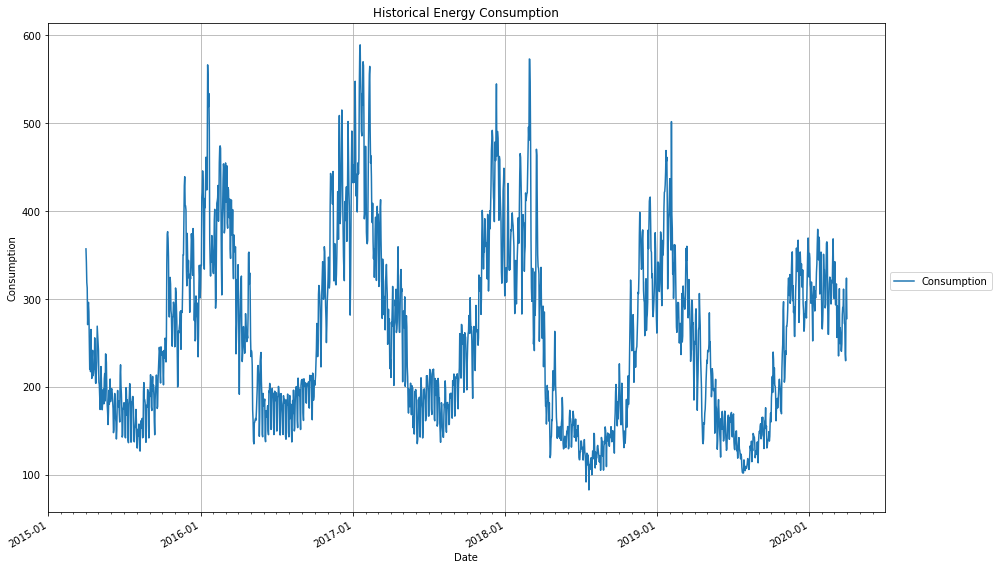

In [6]:
_ = line_plot_date(dat.copy(), "Date", ["Consumption"], "Historical Energy Consumption", ("Date", "Consumption"), None, fig_size=(15, 10))

###  We can observe seasonal / cyclical patterns where in winter (Jan, Feb, Nov, Dec, March) we see the highest mean prices
###  In summer and spring we observe the lowest mean prices (August, July, June, September, May)

In [7]:
dat.groupby(by=["Month"]).agg({"Consumption": ["min", "max", "mean"]}).sort_values(by=[("Consumption", "mean")], ascending=False)

Consumption                     
              min      max        mean
Month                                 
1         252.293  589.269  387.093658
2         236.781  573.178  369.932655
12        234.206  544.815  358.583452
11        199.900  508.875  328.046420
3         184.989  572.805  318.307852
4         119.432  359.461  243.653587
10        130.795  376.677  243.157310
5         129.018  302.473  190.066077
9         109.256  271.057  185.466020
6         117.066  225.095  166.547973
7          82.675  220.194  155.531465
8         105.007  214.634  154.153955

## 1b. We select month and year as features given the month of the year is a driver for consumption

In [8]:
features = ["Consumption", "Month", "Year"]

# 2. Run all algos in src.regression_algorithms.algo_map for a number of iterations

In [9]:
preds = {"algo": [], "preds": [], "accuracy": [], "mse": [], "iter": []}
NUM_DAYS = 365
NUM_ITER = 25   #  10 iterations of running all regression algos takes around 25 seconds
                #  25 iterations of running all regression algos takes around 2 minutes

start_time = datetime.now()
for i in range(NUM_ITER):
    for algo_name, algo in algo_map.items():
        if 'vote_' not in algo_name:  # ignoring voting algos
            res = run_reg_pred(dat[features], "Consumption", NUM_DAYS, algo_name=algo_name)
            preds["preds"].append(res["preds"])
            preds["accuracy"].append(res["accuracy"])
            preds["mse"].append(res["mse"])
            preds["algo"].append(algo_name)
            preds["iter"].append(i)
end_time = datetime.now()

preds_df = pd.DataFrame(preds)
print(f"{NUM_ITER} iterations of running {len(algo_map.keys())} algos took {end_time - start_time} seconds")

25 iterations of running 27 algos took 0:01:39.773431 seconds


In [10]:
preds_df = preds_df.sort_values(by=["accuracy"], ascending=False)
preds_df.reset_index(inplace=True, drop=True)

## 2a. Top 20 model training and prediction runs. Accuracy refers to the accuracy of the TEST split dataset

In [11]:
preds_df.head(20)

,algo,preds,accuracy,mse,iter
0,grad_boost_1,"[250.08562849013148, 259.96970366511334, 260.9...",0.762790,2494.684584,21
1,svr_poly_coef,"[242.5646669027688, 254.52995918078312, 256.64...",0.760915,2510.934533,0
2,svr_poly_scale_coef,"[244.78312659832181, 256.0983566224444, 258.04...",0.759815,2427.389239,15
3,hist_grad_boost_0,"[244.26963645156852, 266.573081390062, 271.127...",0.752886,2456.772895,13
4,grad_boost_1,"[255.0705066888018, 249.72830929577023, 256.57...",0.749105,2686.793402,11
5,hist_grad_boost_0,"[267.5059517554691, 240.73005948928179, 250.48...",0.748803,2721.063657,5
6,svr_poly_scale_coef,"[245.00487963285832, 255.63622653301135, 257.4...",0.747946,2672.893933,18
7,svr_poly_auto_coef,"[240.96048819215173, 252.07753519716945, 254.0...",0.743924,2528.230158,23
8,hist_grad_boost_0,"[247.43315827699453, 222.64827305939897, 273.5...",0.743828,2774.336134,19
9,svr_poly_coef,"[245.7514827366042, 255.0787882653807, 256.710...",0.742514,2934.455134,13


## 2b. Aggregate prediction runs showing best results

In [12]:
preds_df_gp = preds_df.groupby(by=["algo"]).agg({
    "accuracy": ["min", "max", "mean"],
    "mse": ["min", "max", "mean"]})
preds_df_gp = preds_df_gp.sort_values(by=[("accuracy", "mean")], ascending=False)
preds_df_gp

accuracy                              mse  \
                               min       max      mean          min   
algo                                                                  
svr_poly_coef             0.654944  0.760915  0.711884  2482.878904   
grad_boost_1              0.653020  0.762790  0.710316  2494.684584   
svr_poly_scale_coef       0.652920  0.759815  0.706954  2354.697578   
svr_poly_auto_coef        0.668085  0.743924  0.706772  2528.230158   
grad_boost_0              0.649263  0.740522  0.706425  2529.534812   
hist_grad_boost_0         0.647906  0.752886  0.699481  2456.772895   
svr_poly_auto_lerr_coef   0.583022  0.686824  0.648153  2846.699371   
svr_poly_scale_lerr_coef  0.609009  0.706406  0.644982  2925.097744   
svr_linear                0.601854  0.676790  0.641347  3211.325268   
svr_poly_lerr_coef        0.606423  0.672477  0.640968  3136.735035   
randomforest_0            0.595150  0.691130  0.634179  3144.075119   
hist_grad_boost_0_LR      0.594924  0.675759  0.627612  3038.610876   
randomforest_1            0.545203  0.680974  0.626507  2926.748437   
ridge                     0.528965  0.669841  0.599266  3326.198588   
lin_reg                   0.545911  0.651855  0.596860  3696.542697   
grad_boost_0_LR           0.540338  0.623035  0.593491  3417.543474   
lasso                     0.538086  0.668823  0.591457  3345.307257   
elasticnet                0.486070  0.580792  0.534602  3988.012029   
svr_poly_auto             0.370703  0.517237  0.438057  4406.805626   
svr_poly                  0.343571  0.499160  0.436390  4724.412263   
svr_poly_scale            0.343161  0.505731  0.428099  4710.223587   
svr_poly_auto_lerr        0.305321  0.411556  0.357835  5206.694309   
svr_poly_scale_lerr       0.285022  0.401530  0.347747  5556.972664   
svr_poly_lerr             0.289831  0.385900  0.344369  5654.468921   

                                                    
                                  max         mean  
algo                                                
svr_poly_coef             3596.769898  3020.834166  
grad_boost_1              3451.072223  2994.171193  
svr_poly_scale_coef       3766.612527  2960.628035  
svr_poly_auto_coef        3847.065981  3073.806274  
grad_boost_0              3844.553618  3089.871074  
hist_grad_boost_0         3940.753943  3199.224590  
svr_poly_auto_lerr_coef   4782.683116  3673.240466  
svr_poly_scale_lerr_coef  4353.744971  3665.804362  
svr_linear                4163.459667  3758.567750  
svr_poly_lerr_coef        4438.427251  3749.752458  
randomforest_0            4490.576111  3784.383288  
hist_grad_boost_0_LR      4470.825370  3847.445914  
randomforest_1            4996.767472  3846.715587  
ridge                     4904.361806  4099.879559  
lin_reg                   4971.204875  4188.495142  
grad_boost_0_LR           5489.438745  4277.526678  
lasso                     4925.795187  4235.155592  
elasticnet                6307.802755  4912.336127  
svr_poly_auto             6970.763896  5910.592493  
svr_poly                  6565.532107  5794.413580  
svr_poly_scale            6796.918336  5791.884509  
svr_poly_auto_lerr        7731.668951  6713.941224  
svr_poly_scale_lerr       7699.786640  6694.889105  
svr_poly_lerr             8231.227192  6686.415728

## 2c. Get best prediction based on TEST accuracy

In [13]:
best_pred = preds_df.iloc[0]
best_pred

algo                                             grad_boost_1
preds       [250.08562849013148, 259.96970366511334, 260.9...
accuracy                                              0.76279
mse                                               2494.684584
iter                                                       21
Name: 0, dtype: object

In [14]:
best_preds = best_pred["preds"]

In [15]:
last_date = dat.iloc[-1]["Date"]
last_date

Timestamp('2020-03-31 00:00:00')

In [16]:
forecast_dates = [last_date + timedelta(days=x + 1) for x in range(NUM_DAYS)]
assert len(best_preds) == len(forecast_dates)
forecast = {
    "Date": forecast_dates, 
    "Consumption": best_preds
}
forecast_df = pd.DataFrame(forecast)
forecast_df["Forecast_start"] = False
forecast_df.iloc[0, 2] = True  # set first row Forecast_start to True
forecast_df

,Date,Consumption,Forecast_start
0,2020-04-01,250.085628,True
1,2020-04-02,259.969704,False
2,2020-04-03,260.946096,False
3,2020-04-04,243.737120,False
4,2020-04-05,243.086698,False
...,...,...,...
360,2021-03-27,302.106189,False
361,2021-03-28,299.826226,False
362,2021-03-29,284.892935,False
363,2021-03-30,301.530249,False


In [17]:
forecast_df[["Date", "Consumption"]].to_csv(r"data\output\forecast.csv")

In [18]:
full_df = pd.concat([dat, forecast_df], axis=0)
full_df

,Date,Consumption,Forecast_start,Month,Year
0,2015-04-01,357.073000,False,4.0,4.0
1,2015-04-02,341.931000,False,4.0,4.0
2,2015-04-03,318.777000,False,4.0,4.0
3,2015-04-04,312.494000,False,4.0,4.0
4,2015-04-05,270.837000,False,4.0,4.0
...,...,...,...,...,...
360,2021-03-27,302.106189,False,NaN,NaN
361,2021-03-28,299.826226,False,NaN,NaN
362,2021-03-29,284.892935,False,NaN,NaN
363,2021-03-30,301.530249,False,NaN,NaN


## 2d. The red circle dot indicates the starting point of the forecast values
## i.e. all values to the right of the red dot are the forecasted predicted values

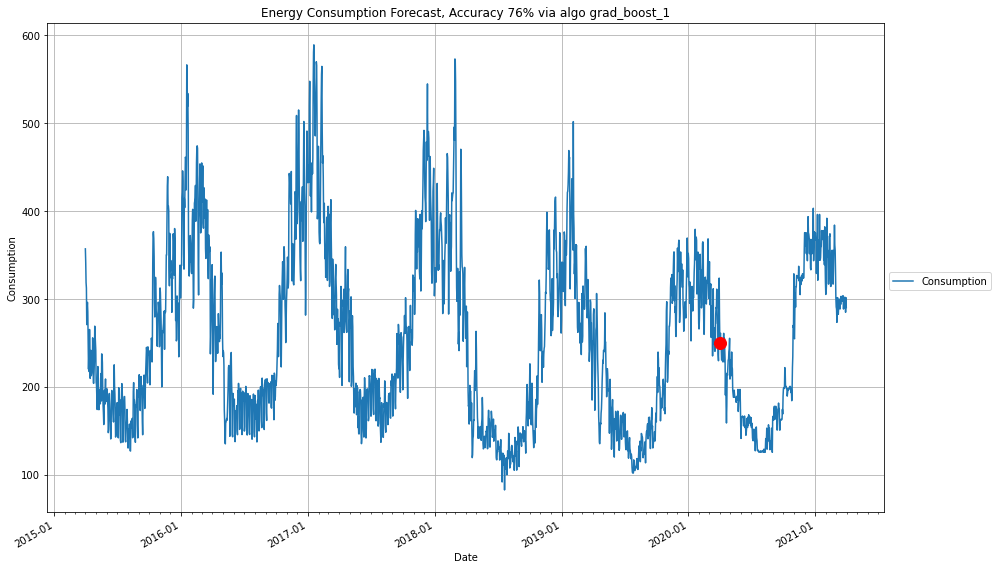

In [19]:
line_plot_date(full_df.copy(), "Date", ["Consumption"], 
               f"Energy Consumption Forecast, Accuracy {round(best_pred['accuracy'] * 100)}% via algo {best_pred['algo']}", 
               ("Date", "Consumption"), r"data\output\forecast.pdf",
               markers={"Forecast_start": ("Consumption", "ro")},
               fig_size=(15, 10))